# Setup

In [ ]:
!pip -q install lightning

# ENV

In [ ]:
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader, random_split

import numpy as np
import pandas as pd
from einops.layers.torch import Rearrange, Reduce
from einops import reduce, rearrange, repeat, einsum, parse_shape, pack, unpack

In [ ]:
import seaborn as sns
sns.set()

import matplotlib
from matplotlib import pyplot as plt
%matplotlib inline
matplotlib.rcParams['lines.linewidth']=2

import matplotlib_inline
matplotlib_inline.backend_inline.set_matplotlib_formats('svg', 'pdf')

In [ ]:
import lightning as L

In [ ]:
seed=42
L.seed_everything(seed)
torch.backends.cudnn.deterministic=True
torch.backends.cudnnbenmark=False
device='cuda' if torch.cuda.is_available() else 'cpu'
device

INFO: Seed set to 42
INFO:lightning.fabric.utilities.seed:Seed set to 42


'cpu'

# Data


In [ ]:
from torchvision import transforms
from torchvision.datasets import CIFAR10
from collections import Counter

class DataModule(L.LightningDataModule):
    def __init__(self, batch_size=32):
        super().__init__()
        self.batch_size=batch_size
        self.transform=transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize((0.1307,), (0.3081,))
        ])

        self.image_size=[3,32,32]
        self.num_classes=10

    def prepare_data(self):
        pass

    def setup(self, stage=None):
        if stage=='fit' or stage is None:
            dataset=CIFAR10('.', download=True, train=True, transform=self.transform)
            self.train, self.val = random_split(dataset, [49000, 1000])
        if stage=='test' or stage is None:
            self.test=CIFAR10('.', download=True, train=False, transform=self.transform)

    def train_dataloader(self):
        return DataLoader(self.train, batch_size=self.batch_size, shuffle=True, drop_last=True)

    def val_dataloader(self):
        return DataLoader(self.val, batch_size=self.batch_size, shuffle=False, drop_last=True)

    def test_dataloader(self):
        return DataLoader(self.test, batch_size=self.batch_size, shuffle=False, drop_last=True)

tmp=DataModule(128)
tmp.setup()
batch=next(iter(tmp.train_dataloader()))
print(len(batch))
print(batch[0].shape)
print(batch[1].shape)

Files already downloaded and verified
Files already downloaded and verified
2
torch.Size([128, 3, 32, 32])
torch.Size([128])


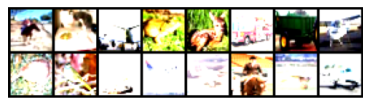

In [ ]:
from torchvision.utils import make_grid

def show_image(images, num_images, image_size=[3,32,32]):
    images=images.detach().cpu()
    grid_image=make_grid(images[:num_images], nrow=8)
    plt.imshow(grid_image.permute(1,2,0))
    plt.axis('off')
    plt.show()

show_image(batch[0],16)

# Architecture

In [ ]:
class ConvBlock(nn.Module):
    def __init__(self, in_channels, out_channels, kernel_size, **kwargs):
        super().__init__()
        self.conv = nn.Conv2d(in_channels, out_channels,kernel_size, **kwargs)

    def forward(self, x):
        x = self.conv(x)
        return F.relu(x, inplace=True)

x=torch.rand([7,3,32,32])
tmp=ConvBlock(3,17, 3)
tmp(x).shape

torch.Size([7, 17, 30, 30])

In [ ]:
class InceptionBlock(nn.Module):
    def __init__(self, in_channels, ch1x1, ch3x3_red, ch3x3, ch5x5_red, ch5x5, pool_proj):
        super().__init__()

        self.b1 = ConvBlock(in_channels, ch1x1, kernel_size=1)

        self.b2 = nn.Sequential(
            ConvBlock(in_channels, ch3x3_red, kernel_size=1),
            ConvBlock(ch3x3_red, ch3x3, kernel_size=3, padding=1),
        )

        self.b3 = nn.Sequential(
            ConvBlock(in_channels, ch5x5_red, kernel_size=1),
            ConvBlock(ch5x5_red, ch5x5, kernel_size=5, padding=2),
        )

        self.b4 = nn.Sequential(
            nn.MaxPool2d(3, stride=1, padding=1),
            ConvBlock(in_channels, pool_proj, kernel_size=1),
        )

    def forward(self, x):
        y1 = self.b1(x)
        y2 = self.b2(x)
        y3 = self.b3(x)
        y4 = self.b4(x)
        return torch.cat([y1, y2, y3, y4], 1)

x=torch.rand([7,3,32,32])
tmp=InceptionBlock(3, 1 ,1 ,1 ,1 ,1 ,1)
tmp(x).shape

torch.Size([7, 4, 32, 32])

In [ ]:
class AuxiliaryClassifier(nn.Module):
    def __init__(self, in_channels, num_classes, drop_rate=0.7, ):
        super().__init__()
        self.layer = nn.Sequential(nn.AvgPool2d(1, stride=3),
                                   ConvBlock(in_channels, 128, kernel_size=1),
                                   nn.ReLU(inplace=False),
                                   Rearrange('b c h w -> b (c h w)'),
                                   nn.Linear(128,1024),
                                   nn.Dropout(drop_rate),
                                   nn.Linear(1024,num_classes))

    def forward(self, x):
        return self.layer(x)


x=torch.rand([7,2,2,2])
tmp=AuxiliaryClassifier(2, 10)
tmp(x).shape

torch.Size([7, 10])

In [ ]:
class GoogLeNet(nn.Module):
    def __init__(self, num_classes, use_aux=True):
        super(GoogLeNet, self).__init__()

        self.use_aux = use_aux
        self.stem = nn.Sequential(
            ConvBlock(3, 64, kernel_size=7, stride=2, padding=3),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(3, stride=2, padding=1),

            ConvBlock(64, 64, kernel_size=1),
            ConvBlock(64, 192, kernel_size=3, padding=1),
            nn.LocalResponseNorm(5, alpha=0.0001, beta=0.75),
            nn.MaxPool2d(3, stride=2, padding=1)
        )

        #block 1
        self.inception3a = InceptionBlock(192, 64, 96, 128, 16, 32, 32)
        self.inception3b = InceptionBlock(256, 128, 128, 192, 32, 96, 64)
        self.maxpool3 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 2
        self.inception4a = InceptionBlock(480, 192, 96, 208, 16, 48, 64)
        self.inception4b = InceptionBlock(512, 160, 112, 224, 24, 64, 64)
        self.inception4c = InceptionBlock(512, 128, 128, 256, 24, 64, 64)
        self.inception4d = InceptionBlock(512, 112, 144, 288, 32, 64, 64)
        self.inception4e = InceptionBlock(528, 256, 160, 320, 32, 128, 128)
        self.maxpool4 = nn.MaxPool2d(3, stride=2, padding=1)

        ## block 3
        self.inception5a = InceptionBlock(832, 256, 160, 320, 32, 128, 128)
        self.inception5b = InceptionBlock(832, 384, 192, 384, 48, 128, 128)

        if self.use_aux:
            self.aux1 = AuxiliaryClassifier(512, 1000)
            self.aux2 = AuxiliaryClassifier(528, 1000)

        self.head=nn.Sequential(
            nn.AvgPool2d(1, stride=1),
            nn.Flatten(),
            nn.Dropout(0.4),
            nn.Linear(1024, num_classes)
        )

    def forward(self, x):
        x=self.stem(x)

        ## block 1
        x = self.inception3a(x)
        x = self.inception3b(x)
        x = self.maxpool3(x)

        ## block 2
        x = self.inception4a(x)
        if self.use_aux:
            aux1 = self.aux1(x)
        x = self.inception4b(x)
        x = self.inception4c(x)
        x = self.inception4d(x)
        if self.use_aux:
            aux2 = self.aux2(x)
        x = self.inception4e(x)
        x = self.maxpool4(x)

        ## block 3
        x = self.inception5a(x)
        x = self.inception5b(x)

        x=self.head(x)

        if self.use_aux:
            return x, aux1, aux2
        else:
            return x

x=torch.rand([7, 3, 32, 32])
tmp=GoogLeNet(10,True)
out,aux_1, aux_2=tmp(x)
out.shape

torch.Size([7, 10])

# Training

In [ ]:
class Training(L.LightningModule):
    def __init__(self, num_classes, lr):
        super().__init__()
        self.save_hyperparameters()
        # self.automatic_optimization=False
        self.model=GoogLeNet(num_classes)
        self.example_input_array = torch.zeros([1, 3, 32, 32], dtype=torch.float32)

    def criterion(self, x_pred, aux_pred_1, aux_pred_2, y):
        loss = 0.5*F.cross_entropy(x_pred,y) + 0.25*F.cross_entropy(aux_pred_1, y)+ 0.25*F.cross_entropy(aux_pred_2,y)
        return loss

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.model.parameters(), lr=self.hparams.lr)
        scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[100, 150], gamma=0.1)
        return [optimizer],[scheduler]

    def forward(self, x):
        self.model.use_aux=False
        return self.model(x)

    def training_step(self, batch):
        image, labels = batch
        self.model.use_aux=True
        x, aux_1, aux_2 = self.model(image)
        loss=self.criterion(x, aux_1, aux_2, labels)
        acc = (x.argmax(dim=-1) == labels).float().mean()

        self.log('train_acc', acc, prog_bar=True)
        self.log('train_loss', loss, prog_bar=True)
        return loss

    def validation_step(self, batch):
        imgs, labels = batch
        self.model.use_aux=False
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('val_acc', acc, prog_bar=True)

    def test_step(self, batch):
        imgs, labels = batch
        self.model.use_aux=False
        preds = self.model(imgs).argmax(dim=-1)
        acc = (labels == preds).float().mean()
        self.log('test_acc', acc, prog_bar=True)


In [ ]:
data_module=DataModule(128)
training=Training(10,1e-3)
trainer = L.Trainer(accelerator='auto',
                    devices=1,
                    max_epochs=50)
trainer.fit(training,data_module)

INFO: GPU available: False, used: False
INFO:lightning.pytorch.utilities.rank_zero:GPU available: False, used: False
INFO: TPU available: False, using: 0 TPU cores
INFO:lightning.pytorch.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO: HPU available: False, using: 0 HPUs
INFO:lightning.pytorch.utilities.rank_zero:HPU available: False, using: 0 HPUs


Files already downloaded and verified


INFO: 
  | Name  | Type      | Params | Mode  | In sizes       | Out sizes
-------------------------------------------------------------------------
0 | model | GoogLeNet | 8.4 M  | train | [1, 3, 32, 32] | [1, 10]  
-------------------------------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.725    Total estimated model params size (MB)
192       Modules in train mode
0         Modules in eval mode
INFO:lightning.pytorch.callbacks.model_summary:
  | Name  | Type      | Params | Mode  | In sizes       | Out sizes
-------------------------------------------------------------------------
0 | model | GoogLeNet | 8.4 M  | train | [1, 3, 32, 32] | [1, 10]  
-------------------------------------------------------------------------
8.4 M     Trainable params
0         Non-trainable params
8.4 M     Total params
33.725    Total estimated model params size (MB)
192       Modules in train mode
0         Modules in e

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO: 
Detected KeyboardInterrupt, attempting graceful shutdown ...
INFO:lightning.pytorch.utilities.rank_zero:
Detected KeyboardInterrupt, attempting graceful shutdown ...


NameError: name 'exit' is not defined